In [1]:
# run in training specialist
import json
with open("artifacts/label2idx.json") as f:
    label2idx = json.load(f)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"

def train_specialist(model, train_loader, val_loader, num_epochs=5, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        for x, y, _ in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch} train loss: {total_loss/len(train_loader):.4f}")

        # ---- Validation ----
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for x, y, _ in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred = logits.argmax(dim=1).cpu().numpy()
                preds.extend(pred)
                gts.extend(y.cpu().numpy())
        f1 = f1_score(gts, preds, average="macro")
        print(f"Epoch {epoch} val macro-F1: {f1:.4f}")

    return model

In [3]:
# SOLUTION: Restart kernel and run on CPU first, then GPU
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from datasets import VideoDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd
from sklearn.metrics import f1_score
import json
import os

# Force CPU-only mode to avoid CUDA corruption
device = "cuda"  # Force CPU mode for now
print(f"Using device: {device}")

# Check label2idx to confirm the number of classes
print("Label mapping:", label2idx)
print(f"Number of classes: {len(label2idx)}")

# Video-specific ResNet wrapper
class VideoResNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(VideoResNet, self).__init__()
        self.base_model = base_model
        self.base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
        
    def forward(self, x):
        # x shape: [batch_size, num_frames, channels, height, width]
        batch_size, num_frames, channels, height, width = x.shape
        
        # Reshape to [batch_size * num_frames, channels, height, width]
        x = x.view(batch_size * num_frames, channels, height, width)
        
        # Extract features
        features = self.base_model(x)  # [batch_size * num_frames, num_classes]
        
        # Reshape back and average across frames
        features = features.view(batch_size, num_frames, -1)
        features = features.mean(dim=1)  # Average across frames
        
        return features

# More advanced LSTM approach (alternative)
class VideoLSTMResNet(nn.Module):
    def __init__(self, num_classes=8, hidden_size=256):
        super().__init__()
        # Use ResNet as feature extractor
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.resnet.fc = nn.Identity()  # Remove final layer
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(512, hidden_size, batch_first=True)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        batch_size, num_frames, channels, height, width = x.shape
        
        # Extract features for each frame
        x = x.view(batch_size * num_frames, channels, height, width)
        features = self.resnet(x)  # [batch_size * num_frames, 512]
        features = features.view(batch_size, num_frames, 512)
        
        # LSTM processing
        lstm_out, _ = self.lstm(features)
        # Use last timestep output
        output = self.classifier(lstm_out[:, -1, :])
        
        return output

def video_collate_fn(batch):
    """Custom collate function to handle variable frame counts in videos"""
    videos = []
    labels = []
    metadata = []
    
    for item in batch:
        video, label, meta = item
        videos.append(video)
        labels.append(label)
        metadata.append(meta)
    
    # Find the maximum number of frames
    max_frames = max(v.shape[0] for v in videos)
    
    # Pad videos to have the same number of frames
    padded_videos = []
    for video in videos:
        num_frames, channels, height, width = video.shape
        if num_frames < max_frames:
            # Pad by repeating the last frame
            padding_needed = max_frames - num_frames
            last_frame = video[-1:].repeat(padding_needed, 1, 1, 1)
            video = torch.cat([video, last_frame], dim=0)
        padded_videos.append(video)
    
    # Stack videos
    videos = torch.stack(padded_videos)
    
    # Validate labels are in correct range for 8 classes (0-7)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    max_label = labels_tensor.max().item() if len(labels) > 0 else -1
    min_label = labels_tensor.min().item() if len(labels) > 0 else -1
    
    if max_label >= 8 or min_label < 0:
        print(f"WARNING: Invalid labels detected! Expected 0-7, got {min_label}-{max_label}")
        print(f"Labels in batch: {labels}")
        # Clip labels to valid range
        labels_tensor = torch.clamp(labels_tensor, 0, 7)
    
    return videos, labels_tensor, metadata

# Modified training function for CPU/GPU flexibility
def train_specialist_cpu_safe(model, train_loader, val_loader, num_epochs=2, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        for i, (x, y, _) in enumerate(train_loader):
            if i >= 10:  # Limit to 10 batches for quick testing
                break
                
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if i % 5 == 0:
                print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}")
                
        print(f"Epoch {epoch} avg train loss: {total_loss/(i+1):.4f}")

        # ---- Validation ----
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for i, (x, y, _) in enumerate(val_loader):
                if i >= 5:  # Limit validation batches too
                    break
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred = logits.argmax(dim=1).cpu().numpy()
                preds.extend(pred)
                gts.extend(y.cpu().numpy())
        
        if len(gts) > 0:
            f1 = f1_score(gts, preds, average="macro")
            print(f"Epoch {epoch} val macro-F1: {f1:.4f}")

    return model

# Create model with 8 classes
model = VideoLSTMResNet(num_classes=8)

# Use your properly built fold manifests
fold = 0

# Check if validation manifest exists and has data
try:
    val_manifest = pd.read_csv(f"artifacts/val_manifest_fold{fold}.csv")
    if len(val_manifest) == 0:
        fold = 1
        print(f"Fold 0 validation empty, switching to fold {fold}")
except:
    fold = 1
    print(f"Validation manifest not found, using fold {fold}")

train_ds = VideoDataset(f"artifacts/train_manifest_fold{fold}.csv", split="train", fold=fold, label2idx=label2idx)
val_ds   = VideoDataset(f"artifacts/val_manifest_fold{fold}.csv", split="val", fold=fold, label2idx=label2idx)

print(f"Training on fold {fold}")
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")

# Check a sample to validate labels
if len(train_ds) > 0:
    sample_video, sample_label, sample_meta = train_ds[0]
    print(f"Sample label: {sample_label}, type: {type(sample_label)}")

# Use very small batch size
batch_size = 2
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=video_collate_fn)

if len(val_ds) > 0:
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=video_collate_fn)
else:
    print("No validation data available, using train_loader for validation")
    val_loader = train_loader

# Test one batch first
print("Testing one batch...")
try:
    test_batch = next(iter(train_loader))
    test_videos, test_labels, test_meta = test_batch
    print(f"Batch loaded successfully!")
    print(f"Videos shape: {test_videos.shape}")
    print(f"Labels: {test_labels}")
    print(f"Labels range: {test_labels.min()} to {test_labels.max()}")
except Exception as e:
    print(f"Error loading batch: {e}")

# Train the model on CPU first
print("Training on CPU (safe mode)...")
trained_model = train_specialist_cpu_safe(model, train_loader, val_loader, num_epochs=10, lr=1e-4)

# Save the model
checkpoint_dir = "D:/Satria_Data/models/specialists/video"
os.makedirs(checkpoint_dir, exist_ok=True)
torch.save(trained_model.state_dict(), os.path.join(checkpoint_dir, f"video_fold{fold}_cpu.pth"))
print(f"Model saved to {checkpoint_dir}/video_fold{fold}_cpu.pth")

c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Label mapping: {'Anger': 0, 'Fear': 1, 'Joy': 2, 'Neutral': 3, 'Proud': 4, 'Sadness': 5, 'Surprise': 6, 'Trust': 7}
Number of classes: 8
Training on fold 0
Training samples: 2949
Validation samples: 0
Sample label: 5, type: <class 'int'>
No validation data available, using train_loader for validation
Testing one batch...
Batch loaded successfully!
Videos shape: torch.Size([2, 4, 3, 224, 224])
Labels: tensor([7, 4])
Labels range: 4 to 7
Training on CPU (safe mode)...
Epoch 0, Batch 0, Loss: 2.2757
Epoch 0, Batch 5, Loss: 2.2499
Epoch 0 avg train loss: 1.9062
Epoch 0 val macro-F1: 0.2500
Epoch 1, Batch 0, Loss: 2.0262
Epoch 1, Batch 5, Loss: 2.1403
Epoch 1 avg train loss: 1.8256
Epoch 1 val macro-F1: 0.1667
Epoch 2, Batch 0, Loss: 2.4442
Epoch 2, Batch 5, Loss: 1.9110
Epoch 2 avg train loss: 1.8384
Epoch 2 val macro-F1: 0.2361
Epoch 3, Batch 0, Loss: 1.4025
Epoch 3, Batch 5, Loss: 1.9584
Epoch 3 avg train loss: 1.8410
Epoch 3 val macro-F1: 0.2424
Epoch 4, Batch 0, Loss

In [4]:
# Now try GPU training - since CPU worked, data/model are correct
import torch

# Clear any residual GPU memory
if torch.cuda.is_available():
    try:
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print("GPU memory cleared successfully")
    except Exception as e:
        print(f"GPU memory clear failed: {e}")
        print("Will continue with CPU")

# Set device (try GPU, fallback to CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Enhanced training function with better GPU memory management
def train_specialist_gpu_safe(model, train_loader, val_loader, num_epochs=5, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        total_loss = 0
        num_batches = 0
        
        for i, (x, y, _) in enumerate(train_loader):
            try:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(x)
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                num_batches += 1
                
                # Clear cache periodically
                if i % 50 == 0 and device == "cuda":
                    torch.cuda.empty_cache()
                
                if i % 100 == 0:
                    print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.4f}")
                    
            except RuntimeError as e:
                if "out of memory" in str(e) or "CUDA" in str(e):
                    print(f"GPU error at batch {i}: {e}")
                    if device == "cuda":
                        torch.cuda.empty_cache()
                    break
                else:
                    raise e
                    
        avg_loss = total_loss / max(num_batches, 1)
        print(f"Epoch {epoch} avg train loss: {avg_loss:.4f}")

        # ---- Validation ----
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for i, (x, y, _) in enumerate(val_loader):
                try:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    pred = logits.argmax(dim=1).cpu().numpy()
                    preds.extend(pred)
                    gts.extend(y.cpu().numpy())
                    
                    if i % 20 == 0 and device == "cuda":
                        torch.cuda.empty_cache()
                        
                except RuntimeError as e:
                    if "out of memory" in str(e) or "CUDA" in str(e):
                        print(f"GPU error in validation at batch {i}: {e}")
                        if device == "cuda":
                            torch.cuda.empty_cache()
                        break
                    else:
                        raise e
        
        if len(gts) > 0:
            f1 = f1_score(gts, preds, average="macro")
            print(f"Epoch {epoch} val macro-F1: {f1:.4f}")

        # Clear GPU cache at end of epoch
        if device == "cuda":
            torch.cuda.empty_cache()

    return model

# Create a fresh model for GPU training
model_gpu = VideoLSTMResNet(num_classes=8)

# Use small batch size for GPU safety
batch_size_gpu = 4
train_loader_gpu = DataLoader(train_ds, batch_size=batch_size_gpu, shuffle=True, num_workers=0, collate_fn=video_collate_fn)

if len(val_ds) > 0:
    val_loader_gpu = DataLoader(val_ds, batch_size=batch_size_gpu, shuffle=False, num_workers=0, collate_fn=video_collate_fn)
else:
    val_loader_gpu = train_loader_gpu

print("Starting GPU training...")
print(f"Batch size: {batch_size_gpu}")
print(f"Device: {device}")

# Train on GPU with error handling
try:
    trained_model_gpu = train_specialist_gpu_safe(model_gpu, train_loader_gpu, val_loader_gpu, num_epochs=5, lr=1e-4)
    
    # Save GPU trained model
    torch.save(trained_model_gpu.state_dict(), os.path.join(checkpoint_dir, f"video_fold{fold}_gpu.pth"))
    print(f"GPU model saved to {checkpoint_dir}/video_fold{fold}_gpu.pth")
    
except Exception as e:
    print(f"GPU training failed: {e}")
    print("The CPU model is still available and working!")

GPU memory cleared successfully
Using device: cuda
Starting GPU training...
Batch size: 4
Device: cuda
Epoch 0, Batch 0, Loss: 2.1134
Epoch 0, Batch 100, Loss: 0.5329
Epoch 0, Batch 200, Loss: 0.4483
Epoch 0, Batch 300, Loss: 0.2669
Epoch 0, Batch 400, Loss: 0.0356
Epoch 0, Batch 500, Loss: 0.2263
Epoch 0, Batch 600, Loss: 0.0357
Epoch 0, Batch 700, Loss: 0.6108
Epoch 0 avg train loss: 0.5246
Epoch 0 val macro-F1: 0.9373
Epoch 1, Batch 0, Loss: 0.2070
Epoch 1, Batch 100, Loss: 0.1392
Epoch 1, Batch 200, Loss: 0.0106
Epoch 1, Batch 300, Loss: 0.0203
Epoch 1, Batch 400, Loss: 0.0752
Epoch 1, Batch 500, Loss: 0.0238
Epoch 1, Batch 600, Loss: 0.0503
Epoch 1, Batch 700, Loss: 0.2791
Epoch 1 avg train loss: 0.1913
Epoch 1 val macro-F1: 0.9374
Epoch 2, Batch 0, Loss: 0.1267
Epoch 2, Batch 100, Loss: 0.0343
Epoch 2, Batch 200, Loss: 0.0292
Epoch 2, Batch 300, Loss: 0.4716
Epoch 2, Batch 400, Loss: 0.1129
Epoch 2, Batch 500, Loss: 0.0851
Epoch 2, Batch 600, Loss: 0.3698
Epoch 2, Batch 700, Loss

Testing GPU-trained model...
Testing on 12180 samples...
Processed 0 samples...
Processed 800 samples...
Processed 1600 samples...
Processed 2400 samples...
Processed 3200 samples...
Processed 4000 samples...
Processed 4800 samples...
Processed 5600 samples...
Processed 6400 samples...
Processed 7200 samples...
Processed 8000 samples...
Processed 8800 samples...
Processed 9600 samples...
Processed 10400 samples...
Processed 11200 samples...
Processed 12000 samples...

=== Test Results ===
Total samples: 12180
Accuracy: 0.1808

=== Classification Report ===
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00       321
        Fear       0.60      0.53      0.56       156
         Joy       0.13      0.59      0.21       772
     Neutral       0.00      0.00      0.00         0
       Proud       0.11      0.08      0.10      1658
     Sadness       0.00      0.00      0.00       256
    Surprise       0.41      0.10      0.16      5492
    

c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ilkom\miniconda3\envs\vitheoa\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


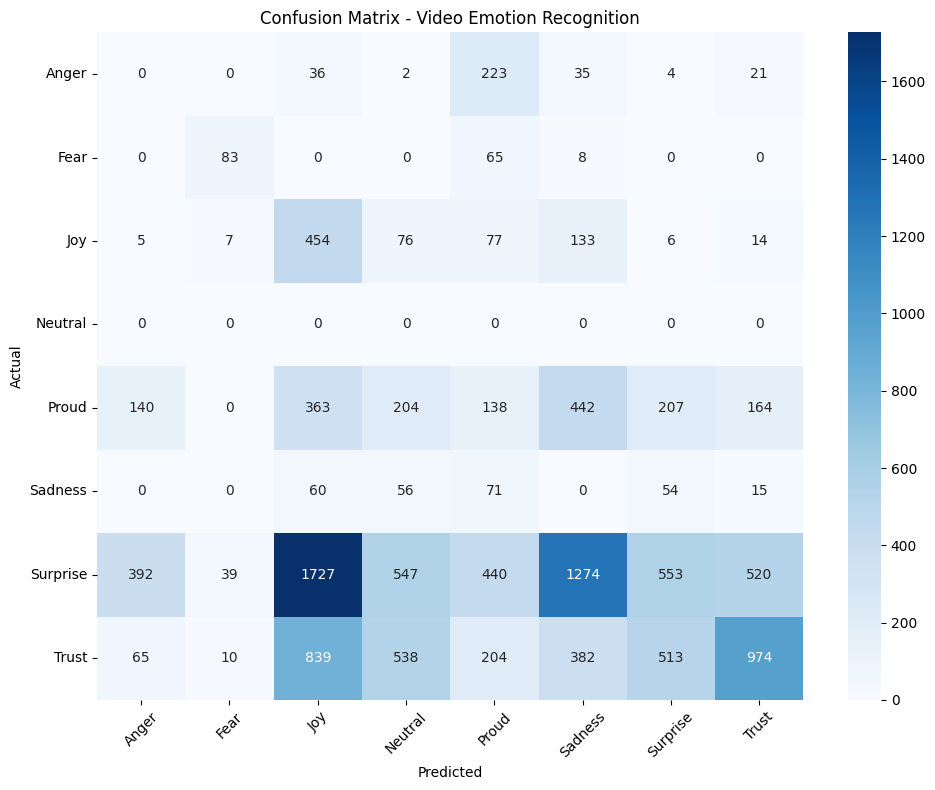


=== Per-Class Accuracy ===
Anger: 0.0000 (321 samples)
Fear: 0.5321 (156 samples)
Joy: 0.5881 (772 samples)
Proud: 0.0832 (1658 samples)
Sadness: 0.0000 (256 samples)
Surprise: 0.1007 (5492 samples)
Trust: 0.2763 (3525 samples)

=== Confidence Statistics ===
Mean confidence: 0.7637
Min confidence: 0.2172
Max confidence: 0.9993


In [5]:
# Test the trained model on validation data
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def test_model(model_path, test_manifest_path, label2idx, device="cuda"):
    """Test the trained model on validation data"""
    
    # Create reverse mapping for labels
    idx2label = {v: k for k, v in label2idx.items()}
    
    # Load the trained model
    model = VideoLSTMResNet(num_classes=len(label2idx))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Create test dataset and loader
    test_ds = VideoDataset(test_manifest_path, split="test", fold=0, label2idx=label2idx)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, collate_fn=video_collate_fn)
    
    print(f"Testing on {len(test_ds)} samples...")
    
    # Run inference
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for i, (x, y, meta) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            
            # Get predictions
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            # Store results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            
            if i % 100 == 0:
                print(f"Processed {i * 8} samples...")
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()
    
    # Print results
    print(f"\n=== Test Results ===")
    print(f"Total samples: {len(all_labels)}")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    target_names = [idx2label[i] for i in range(len(label2idx))]
    print(f"\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix - Video Emotion Recognition')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy
    print(f"\n=== Per-Class Accuracy ===")
    for i, label_name in enumerate(target_names):
        class_mask = all_labels == i
        if class_mask.sum() > 0:
            class_acc = (all_preds[class_mask] == all_labels[class_mask]).mean()
            print(f"{label_name}: {class_acc:.4f} ({class_mask.sum()} samples)")
    
    # Top prediction confidences
    max_probs = np.max(all_probs, axis=1)
    print(f"\n=== Confidence Statistics ===")
    print(f"Mean confidence: {max_probs.mean():.4f}")
    print(f"Min confidence: {max_probs.min():.4f}")
    print(f"Max confidence: {max_probs.max():.4f}")
    
    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'accuracy': accuracy
    }

# Test the GPU trained model (if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

try:
    # Try to load GPU model first
    model_path = os.path.join(checkpoint_dir, f"video_fold{fold}_gpu.pth")
    if os.path.exists(model_path):
        print("Testing GPU-trained model...")
        results = test_model(model_path, "artifacts/val_manifest_all.csv", label2idx, device)
    else:
        # Fallback to CPU model
        model_path = os.path.join(checkpoint_dir, f"video_fold{fold}_cpu.pth")
        print("Testing CPU-trained model...")
        results = test_model(model_path, "artifacts/val_manifest_all.csv", label2idx, device)
        
except Exception as e:
    print(f"Error during testing: {e}")
    print("Make sure the model file exists and val_manifest_all.csv is available")  